In [1]:
from __future__ import division

import collections
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from sklearn.decomposition import PCA

## NN libs
import keras
from keras import backend as K
from keras import regularizers
from keras.utils import to_categorical
from keras.optimizers import SGD, Adam
from keras.layers import *
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.callbacks import TensorBoard

/usr/local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using Theano backend.


In [2]:
import config
import os, numpy as np, pandas, sklearn, scipy.signal as signal
import mido
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# local libs
import config, models, setup, compression, ncd_evaluation
import midi
import midi.decode
from midi import generators as g
from utils import io, models_io, utils, plot, string
from capsule.layers import Capsule, Length
from capsule.capsulefunctions import squash, softmax, margin_loss

In [4]:
context = setup.init(max_bars=4)

 Context :: namedtuple(
[ max_t = float
, dt = float
, n_timestesp = int
, note_length = int
, bpm = float
, tempo = float
, ticks_per_beat = int
]

Setting up params

max min f 20.0 0.25
 >> Context(max_t=4.0, dt=0.025, n_timesteps=160, note_length=0.03, bpm=120.0, tempo=500000, ticks_per_beat=480)
 sample length:  160.000000
 max_f: 20.000000, min_f: 0.250000


In [5]:
n = 500 * 2
dim4 = True
multiTrack = True
reduce_dims = midi.ReduceDimsOptions.NONE # GLOBAL
dn = 'drum_midi/'
v = None # float | None
x_train, labels = setup.import_data(context, n, dim4=dim4, reduce_dims=reduce_dims, 
    dirname=dn, multiTrack=multiTrack, velocity=v, r=True)
n = 500


Importing midi-data
walk_and_search(../datasets/drum_midi/)
path ../datasets/drum_midi/
path ../datasets/drum_midi/50´s Drummer MIDI Files
path ../datasets/drum_midi/50´s Drummer MIDI Files/01 Rock'n'Roll
path ../datasets/drum_midi/50´s Drummer MIDI Files/01 Rock'n'Roll/01 Dancin Rick 166BPM
  01 8th Hat.mid
  02 8th Ride.mid
  03 16th Snare.mid
  04 8th Ride.mid
  05 16th Ride.mid
  06 16th Ride.mid
  07 16th Ride.mid
path ../datasets/drum_midi/50´s Drummer MIDI Files/01 Rock'n'Roll/02 Gogo 191BPM
  01 8th Hat.mid
  02 8th Snare.mid
  03 4th Snare .mid
  04 8th Ride.mid
  05 8th Snare.mid
  06 8th Toms.mid
  07 8th Toms.mid
path ../datasets/drum_midi/50´s Drummer MIDI Files/01 Rock'n'Roll/03 Lips n Hips 152BPM
  01 8th Perc.mid
  02 8th Ride.mid
  03 8th Ride .mid
  04 8th Snare.mid
  05 8th Snare.mid
  06 8th Hat.mid
  07 8th Snare.mid
path ../datasets/drum_midi/50´s Drummer MIDI Files/01 Rock'n'Roll/04 Maybelline 233BPM
  01 8th Snare.mid
  02 8th Cym.mid
  03 8th Ride.mid
  04 16t

path ../datasets/drum_midi/50´s Drummer MIDI Files/07 Indie/19 Distant Floor 119BPM
  01 4th Multi.mid
  02 16th Multi.mid
  03 4th Multi.mid
  04 4th Multi.mid
  05 8th Multi.mid
  06 4th Multi.mid
  07 16th Multi.mid
path ../datasets/drum_midi/50´s Drummer MIDI Files/07 Indie/20 So Simple 102BPM
  01 8th Hat.mid
  02 8th Perc.mid
  03 8th Perc.mid
  04 8th Perc.mid
  05 16th Hat.mid
  06 16th Hat.mid
  07 8th Cym.mid
path ../datasets/drum_midi/60´s Drummer MIDI Files
path ../datasets/drum_midi/60´s Drummer MIDI Files/Early Kit
path ../datasets/drum_midi/60´s Drummer MIDI Files/Early Kit/01 Rock n Roll
path ../datasets/drum_midi/60´s Drummer MIDI Files/Early Kit/01 Rock n Roll/01 Shuffle 186BPM
  01 8th Snare Perc.mid
  02 8th Snare Perc.mid
  03 8th Snare Perc.mid
  04 8th Snare Perc.mid
  05 8th Snare Perc.mid
  06 8th Snare Perc.mid
  07 8th Perc.mid
  08 8th Perc.mid
  09 8th Toms.mid
  10 8th Cym.mid
  11 8th Cym.mid
  12 8th Cym.mid
  13 4th Cym.mid
  14 8th Hat Both.mid
  15 8t


Encoding midi-data
 1000
> -> multi-track = True none
 [INFO] : 
 |  True


In [6]:
genres = [string.extract_labels_from_filename(k) for k in labels]
# genre_dict = setup.build_label_dict(genres)

In [7]:
# [(i,k) for i,k in enumerate(labels[:n])]

In [8]:
genres[0][-2:]

["01 Rock'n'Roll", '01 Dancin Rick 166BPM']

In [9]:
unique_genres = set(genre[-1] for genre in genres)

In [10]:
# genres = [string.extract_labels_from_filename(k) for k in labels]
genre_dict = setup.build_label_dict(genres)
labels_ = [label.split('/') for label in labels]
label_dict = setup.build_label_dict(labels_)

In [11]:
input_shape = x_train[0].shape
timesteps = input_shape[0]
notes = input_shape[1]
input_shape

(160, 10, 1)

In [12]:
latent_dim = 10
epsilon_std = 1.0
batch_size = 128
epochs = 500

name = 'non-functional_model.h5'
fn = config.model_dir + name

In [13]:
vae, encoder, generator = models.build(input_shape, latent_dim)
vae.load_weights(fn)

/usr/local/lib/python3.6/site-packages/keras/layers/core.py:642: UserWarning: `output_shape` argument not specified for layer lambda_2 and cannot be automatically inferred with the Theano backend. Defaulting to output shape `[(None, 10), (None, 10)]` (same as input shape). If the expected output shape is different, specify it via the `output_shape` argument.
  .format(self.name, input_shape))
/Users/mark/src/pattern-recognition/src/models.py:147: UserWarning: Output "decoder_model-" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "decoder_model-" during training.
  vae.compile(optimizer='adam')


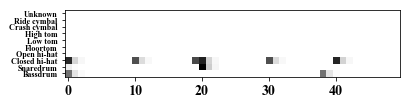

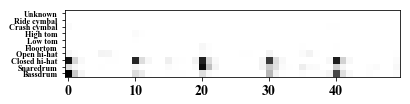

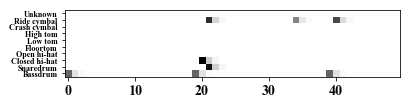

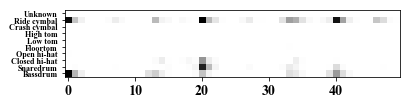

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/site-packages/matplotlib/pyplot.py'>

In [14]:
i,j = 0, 10
m = 50
y = vae.predict(x_train[:500])
plot.single(x_train[i,:m])
plot.single(y[i,:m])
plot.single(x_train[j,:m])
plot.single(y[j,:m])

## Style transfer

In [15]:
m = 500
x_train_encoded = encoder.predict(x_train[:m], batch_size=batch_size)
x_train_encoded.shape
gd = genre_dict

In [16]:
one_to_one = False
one_to_one = True

dn = config.plots_dir
if one_to_one:
    transformations = io.load(dn + 'transformations-one-to-one.pkl')
    min_transformations = io.load(dn + 'min_transformations-one-to-one.pkl')    
    labelled_result = io.load(dn + 'ncd_evaluation-one-to-one_AB.pkl')
    labelled_result_min = io.load(dn + 'ncd_evaluation-one-to-one_AB_min.pkl')
    genre_dict = label_dict
else:
    best_dims = io.load(dn + 'transformations-best_dims.pkl')
    transformations = io.load(dn + 'transformations.pkl')
    min_transformations = io.load(dn + 'min_transformations.pkl')
    labelled_result = io.load(dn + 'ncd_evaluation_AB.pkl')
    labelled_result_min = io.load(dn + 'ncd_evaluation_AB_min.pkl')
    genre_dict = gd

In [17]:
def sample_dict(d, i=0):
    k = list(d.keys())[i]
    return k, d[k]

In [18]:
# utils.reload(utils)
labelled_result = utils.clean_dict(labelled_result, r=2, verbose=1)

In [19]:
# utils.reload(utils)
sample = utils.get(labelled_result, i=10)[0]
sample

'02 Boogaloo 120BPM/02 4th Multi.mid'

In [20]:
# labelled_result[sample]

In [21]:
genre_a = utils.get(labelled_result[sample])[0]
genre_b,_, scores = utils.get(labelled_result[sample][genre_a])
scores_min = utils.get(labelled_result[sample][genre_a])[2]
xlabels = np.round(list(scores.keys()), 2)
genre_a, genre_b

('02 Boogaloo 120BPM/02 4th Multi.mid', '08 Doowoop 140bpm/01 16th Snare.mid')

In [51]:
# # for k,v in scores.items():
# #     print('%s: \t%f' % (k,v))
# print(xlabels)
# plot.custom({sample: list(scores.values())}, options={'x_labels': xlabels},
#             type_='bar', y_scale_margin=0.01,figsize=(10,3), show=True)

In [52]:
# plot.custom({sample: list(scores_min.values())}, options={'x_labels': xlabels},
#             type_='bar', y_scale_margin=0.01,figsize=(10,3), show=True)

In [24]:
genre_dict[sample], sample

([358], '02 Boogaloo 120BPM/02 4th Multi.mid')

Original


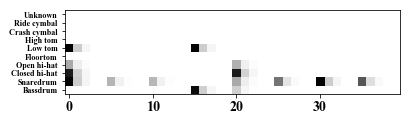

Identity (transformation)


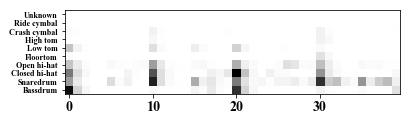

In [25]:
utils.reload(plot, midi.pitches)
z_sample = x_train_encoded[genre_dict[genre_a][0]]
print('Original')
plot.single(x_train[genre_dict[sample][0]][:40])
print('Identity (transformation)')
plot.single(generator.predict(np.array([z_sample]))[0,:40]);

In [26]:
transformation = transformations[genre_a][genre_b]
min_transformation = min_transformations[genre_a][genre_b]
z_transformed = []
z_transformed_min = []
d = {}
for a in [0, 0.125, 0.2, 0.21, 0.22, 0.24]:
    z_ = models.apply_transformation(z_sample, transformation, a)
    z_transformed.append(z_)
    z_ = models.apply_transformation(z_sample, min_transformation, a)
    z_transformed_min.append(z_)

x_generated = generator.predict(np.array(z_transformed))
x_generated_min = generator.predict(np.array(z_transformed_min))

02 Boogaloo 120BPM/02 4th Multi.mid 
  02 Boogaloo 120BPM/02 4th Multi.mid 	-> 08 Doowoop 140bpm/01 16th Snare.mid 


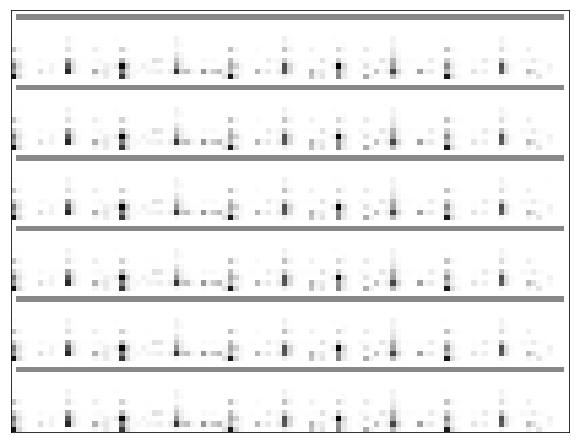

In [27]:
print('%s \n  %s \t-> %s '%(sample, genre_a, genre_b))
# latent_space = models.gen_latent(generator, latent_dim=latent_dim, n=3, m=2, plot_result=True)
plot.multi(x_generated, crop_size=100)

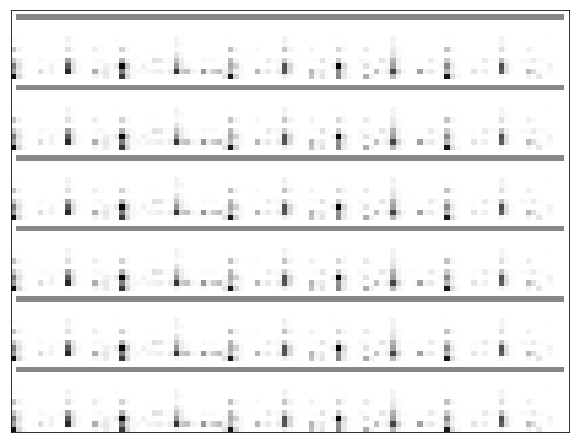

In [28]:
plot.multi(x_generated_min, crop_size=100)

In [29]:
# utils.reload(midi, midi.decode)
for i in range(x_generated.shape[0]):
    x_ = x_generated[i]
    mid = midi.decode.track(context, x_)
    io.export_midifile(mid, config.export_dir + ('x-generated-%i'%i))
    x_ = x_generated_min[i]
    mid = midi.decode.track(context, x_)    
    io.export_midifile(mid, config.export_dir + ('x-generated_min-%i'%i))    

 [INFO] : 
 |  len, max_t
 |  3.9052083333333334
 |  4.0
 [INFO] : 
 |  len, max_t
 |  3.9052083333333334
 |  4.0
 [INFO] : 
 |  len, max_t
 |  3.9052083333333334
 |  4.0
 [INFO] : 
 |  len, max_t
 |  3.9052083333333334
 |  4.0
 [INFO] : 
 |  len, max_t
 |  3.9052083333333334
 |  4.0
 [INFO] : 
 |  len, max_t
 |  3.9052083333333334
 |  4.0
 [INFO] : 
 |  len, max_t
 |  3.9052083333333334
 |  4.0
 [INFO] : 
 |  len, max_t
 |  3.9052083333333334
 |  4.0
 [INFO] : 
 |  len, max_t
 |  3.9052083333333334
 |  4.0
 [INFO] : 
 |  len, max_t
 |  3.9052083333333334
 |  4.0
 [INFO] : 
 |  len, max_t
 |  3.9052083333333334
 |  4.0
 [INFO] : 
 |  len, max_t
 |  3.9052083333333334
 |  4.0


In [30]:
def summarize(data):
    """data :: {samples: {genre a: {genre b: grid}}}
    grid = {parameter: outcome}
    
    return :: {parameter: [value] }
    """
    summary = collections.defaultdict(list)
    for original in data.keys():
        for genre_a in data[original].keys():
            for genre_b, grid in data[original][genre_a].items():
                for k,v in grid.items():
                    summary[k].append(v)
    return summary

def evaluate(data, verbose=0):
    """
    data :: {parameter: [value] }
    return :: {statistic: {parameter: value}}
    """
    result = utils.summary_multi(data, mode=list)
    std = []
    for k,v in data.items():
        std.append(np.std(v))
    
    result['std'] = std
    if verbose: 
        print(result['mean'])
    return result

In [31]:
result = summarize(labelled_result)
result_min = summarize(labelled_result_min)
xlabels = np.round(list(result.keys()), 3)
summary = evaluate(result)
summary_min = evaluate(result_min)
summary_ = summary.copy() # {'Mean': summary['mean'], 'Median': summary['median']}
summary_min_ = summary_min.copy()
summary_.pop('std')
summary_min_.pop('std');

In [32]:
io.save_dict(config.results_dir, 'ncd_result-summary', summary)
io.save_dict(config.results_dir, 'ncd_result_min-summary', summary_min)

'../results/ncd_result_min-summary.csv'

In [33]:
xlabels

array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ])

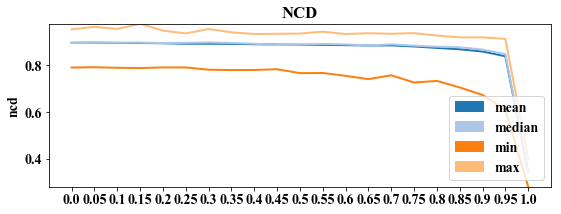

In [92]:
options = {'x_labels': xlabels, 'x_label':'Transformation intensity', 'y_label': 'ncd', 'legend':True}
plot.custom(summary_, 'NCD', options,
            type_='line', min_y_scale=None, max_y_scale=None, y_scale_margin=0.0001,figsize=(9,3), show=True)

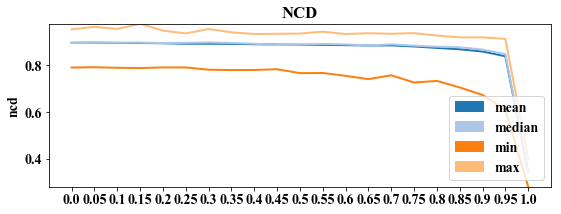

In [93]:
plot.custom(summary_, 'NCD', options,
            type_='line', min_y_scale=None, max_y_scale=None, y_scale_margin=0.0001,figsize=(9,3), show=True)

In [56]:
summary['mean']

[0.8959936347886465,
 0.8964423481327146,
 0.8953725129805147,
 0.8950777716186213,
 0.8938402216387309,
 0.8917668320743983,
 0.8918977860859879,
 0.8912597189771212,
 0.8897382182543614,
 0.8882630825434946,
 0.8876484690516832,
 0.8870146529833498,
 0.8857965952152654,
 0.8842347789606577,
 0.8846637500118799,
 0.8801049564549668,
 0.8739672171117052,
 0.8682151570056819,
 0.8584858418527886,
 0.8384155111340355,
 0.34366520173563087]

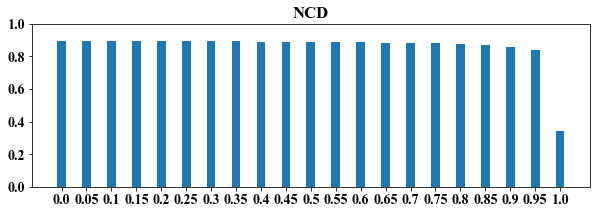

In [69]:
# utils.reload(plot)
options = {'x_labels': xlabels}
# custom(summary, 'NCD', options, relative=True, show=True)
plot.custom({'Mean':summary['mean']}, 'NCD', options, type_='bar', min_y_scale=0, max_y_scale=1, 
            y_scale_margin=0.01,figsize=(10,3), show=True)

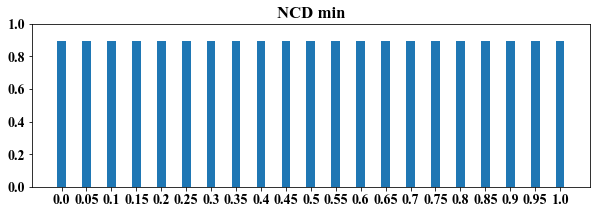

In [68]:
plot.custom({'Mean':summary_min['mean']}, 'NCD min', options, type_='bar', min_y_scale=0, max_y_scale=1, 
            y_scale_margin=0.01, figsize=(10,3), show=True)

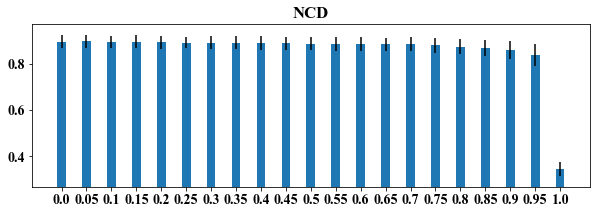

In [73]:
# utils.reload(plot)
options = {'x_labels': xlabels,}
# custom(summary, 'NCD', options, relative=True, show=True)
std = {'Mean': summary['std'], 'Median': summary['std']}
plot.custom({'Mean':summary['mean']}, 'NCD', options, type_='bar',std=std,figsize=(10,3), min_y_scale=None, max_y_scale=None, y_scale_margin=0.03, show=True)

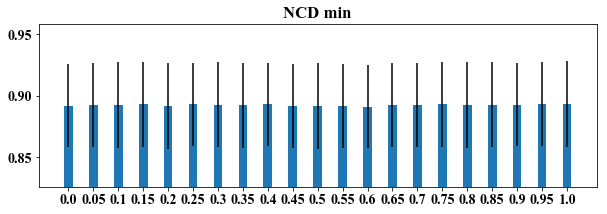

In [86]:
std_min = {'Mean': summary_min['std'], 'Median': summary_min['std']}
plot.custom({'Mean':summary_min['mean']}, 'NCD min', options,dn='../', type_='bar',std=std_min,figsize=(10,3), min_y_scale=None, max_y_scale=None, y_scale_margin=0.03, show=True)

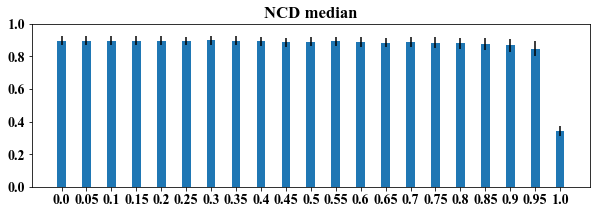

In [85]:
# utils.reload(plot)
plot.custom({'Median':summary['median']}, 'NCD median', options, type_='bar', figsize=(10,3),std=std, show=True)

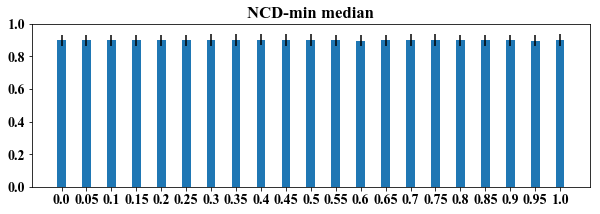

In [79]:
plot.custom({'Median':summary_min['median']}, 'NCD-min median', options, type_='bar',figsize=(10,3), std=std_min, show=True)

In [43]:
result.keys()

dict_keys([0.0, 0.05, 0.1, 0.15000000000000002, 0.2, 0.25, 0.30000000000000004, 0.35000000000000003, 0.4, 0.45, 0.5, 0.55, 0.6000000000000001, 0.65, 0.7000000000000001, 0.75, 0.8, 0.8500000000000001, 0.9, 0.9500000000000001, 1.0])

In [44]:
import scipy.stats

In [45]:
# assume all distributions are related, do not shuffle
# i.e. param1[0] is related to param2[0]
def evaluate(data, base_k=0, f=scipy.stats.ttest_rel, p=0.05,win_c=lambda x,y: x>y):
    result = {}
    base_v = data[base_k]
    for k,v in data.items():
        if len(v) < 1:
            raise(ValueError('Warning: len(v) == %i for k: %s'%(len(v), str(k))))
        if not k == base_k:
            score = scipy.stats.ttest_rel(base_v, v)
            won = win_c(np.mean(base_v), np.mean(v))
            significant = score.pvalue < p
            result['%s/%s' % (base_k,k)] = (won, significant)
            print('%s vs %s: \t' % (base_k, k), won, significant, round(score.pvalue,4))

In [46]:
evaluate(result)

0 vs 0.05: 	 False False 0.788
0 vs 0.1: 	 True False 0.7056
0 vs 0.15000000000000002: 	 True False 0.5498
0 vs 0.2: 	 True False 0.2511
0 vs 0.25: 	 True True 0.0296
0 vs 0.30000000000000004: 	 True False 0.0765
0 vs 0.35000000000000003: 	 True True 0.0289
0 vs 0.4: 	 True True 0.0087
0 vs 0.45: 	 True True 0.0003
0 vs 0.5: 	 True True 0.0008
0 vs 0.55: 	 True True 0.0012
0 vs 0.6000000000000001: 	 True True 0.0002
0 vs 0.65: 	 True True 0.0
0 vs 0.7000000000000001: 	 True True 0.0001
0 vs 0.75: 	 True True 0.0
0 vs 0.8: 	 True True 0.0
0 vs 0.8500000000000001: 	 True True 0.0
0 vs 0.9: 	 True True 0.0
0 vs 0.9500000000000001: 	 True True 0.0
0 vs 1.0: 	 True True 0.0


In [47]:
evaluate(result_min)

0 vs 0.05: 	 False False 0.4874
0 vs 0.1: 	 False False 0.6919
0 vs 0.15000000000000002: 	 False False 0.0906
0 vs 0.2: 	 True False 0.6938
0 vs 0.25: 	 False False 0.1045
0 vs 0.30000000000000004: 	 False False 0.165
0 vs 0.35000000000000003: 	 False False 0.5271
0 vs 0.4: 	 False False 0.0838
0 vs 0.45: 	 True False 0.9846
0 vs 0.5: 	 False False 0.9181
0 vs 0.55: 	 True False 0.6666
0 vs 0.6000000000000001: 	 True False 0.2891
0 vs 0.65: 	 False False 0.7413
0 vs 0.7000000000000001: 	 False False 0.3501
0 vs 0.75: 	 False False 0.185
0 vs 0.8: 	 False False 0.7011
0 vs 0.8500000000000001: 	 False False 0.1896
0 vs 0.9: 	 False False 0.3068
0 vs 0.9500000000000001: 	 False False 0.1725
0 vs 1.0: 	 False False 0.0651


In [48]:
evaluate(result_min, base_k=0, f=scipy.stats.ttest_ind)

0 vs 0.05: 	 False False 0.4874
0 vs 0.1: 	 False False 0.6919
0 vs 0.15000000000000002: 	 False False 0.0906
0 vs 0.2: 	 True False 0.6938
0 vs 0.25: 	 False False 0.1045
0 vs 0.30000000000000004: 	 False False 0.165
0 vs 0.35000000000000003: 	 False False 0.5271
0 vs 0.4: 	 False False 0.0838
0 vs 0.45: 	 True False 0.9846
0 vs 0.5: 	 False False 0.9181
0 vs 0.55: 	 True False 0.6666
0 vs 0.6000000000000001: 	 True False 0.2891
0 vs 0.65: 	 False False 0.7413
0 vs 0.7000000000000001: 	 False False 0.3501
0 vs 0.75: 	 False False 0.185
0 vs 0.8: 	 False False 0.7011
0 vs 0.8500000000000001: 	 False False 0.1896
0 vs 0.9: 	 False False 0.3068
0 vs 0.9500000000000001: 	 False False 0.1725
0 vs 1.0: 	 False False 0.0651
